In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.stats as s
import astropy.units as u
import astropy.constants as c
import astropy.visualization.wcsaxes as v
import astropy.coordinates as coord
import scipy.interpolate as interp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import matplotlib.offsetbox
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from reproject import reproject_interp

import pandas as pd

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.stats import sigma_clip
from photutils.aperture import SkyCircularAperture, CircularAperture, ApertureStats

from spectral_cube import SpectralCube
from radio_beam import beam
from regions import Regions

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
})

In [2]:
#make sure you drop degenerate axes in M0 maps using carta
source_name='G351.77'
path = '/net/vdesk/data2/bach1/ballieux/master_project_2/data/high_mass_data/'+source_name+'/' # Path to the data
B6_red_name = 'region_selection/CO21_M0_20_90_dropped_axes.fits'    #M0 map of the CO 2-1 line, band 6, redshifted
B7_red_name = 'region_selection/CO32_M0_20_90_dropped_axes.fits'    #M0 map of the CO 3-2 line, band 7, redshifted
B6_blue_name = 'region_selection/CO21_M0_-120_-13_dropped_axes.fits'    #M0 map of the CO 2-1 line, band 6, blueshifted
B7_blue_name = 'region_selection/CO32_M0_-120_-13_dropped_axes.fits'    #M0 map of the CO 3-2 line, band 7, blueshifted

red_velrange='20_90'
blue_velrange = '-120_-13'
red_velrange_text='20;90'
blue_velrange_text = '-120;-13'
d = 2.0 * u.kpc
e_d = 0.7 * u.kpc
 
#Open the fits files
hdu_B6_red = fits.open(path+B6_red_name)
hdu_B7_red = fits.open(path+B7_red_name)
hdu_B6_blue = fits.open(path+B6_blue_name)
hdu_B7_blue = fits.open(path+B7_blue_name)

# Always manually check the beam is exactly the same for both maps, and check unit of major axis
beam_major = hdu_B6_red[0].header['BMAJ']*3600 *u.arcsec # Beam major axis size in arcseconds
beam_minor = hdu_B6_red[0].header['BMIN']*3600 *u.arcsec # Beam minor axis size in arcseconds
beam_pa = hdu_B6_red[0].header['BPA']*u.deg  # Beam position angle in degrees

#get the pixel size form the header
pixel_size=0.16 *u.arcsec #Make sure it is the one you regrid the other to
beam_major_pix = beam_major/pixel_size # Beam major axis size in pixels, incorrect, also does it need to be different for the different bands?
beam_minor_pix = beam_minor/pixel_size # Beam major axis size in pixels, incorrect, also does it need to be different for the different bands?

#The WCS object is used to convert between pixel and world coordinates
wcs_B6_red = WCS(hdu_B6_red[0].header)
wcs_B7_red = WCS(hdu_B7_red[0].header)
wcs_B6_blue = WCS(hdu_B6_blue[0].header)
wcs_B7_blue = WCS(hdu_B7_blue[0].header)

#One of the images needs to be regridded, this can be done because both are well sampled
#Always check which one has the highest resolution, and regrid the other to that one
B6_red = hdu_B6_red[0].data *u.Jy*u.km/u.s
B7_red, footprint_red = reproject_interp(hdu_B7_red[0], hdu_B6_red[0].header) *u.Jy*u.km/u.s  #regridded
B6_blue = hdu_B6_blue[0].data *u.Jy*u.km/u.s
B7_blue, footprint_blue = reproject_interp(hdu_B7_blue[0], hdu_B6_blue[0].header) *u.Jy*u.km/u.s  #regridded

#RMS calculation
B6_red_rms_name = 'region_selection/CO21_M0_'+ red_velrange+ '_rms.fits'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter
B7_red_rms_name = 'region_selection/CO32_M0_'+ red_velrange+ '_rms.fits'    #empty region of M0 map of the CO 3-2 line, band 7, shape does not matter
B6_blue_rms_name = 'region_selection/CO21_M0_'+ blue_velrange+ '_rms.fits'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter
B7_blue_rms_name = 'region_selection/CO32_M0_'+ blue_velrange+ '_rms.fits'    #empty region of M0 map of the CO 3-2 line, band 7, shape does not matter

#This is now just an empty region of the map to get rms level. Later convolve with 10%
hdu_B6_red_err = fits.open(path+B6_red_rms_name)
hdu_B7_red_err = fits.open(path+B7_red_rms_name)
hdu_B6_blue_err = fits.open(path+B6_blue_rms_name)
hdu_B7_blue_err = fits.open(path+B7_blue_rms_name)

#Here we take the not-nan values to calculate the rms. The other images do still contain nan values
B6_red_rms = np.sqrt(np.mean(np.square(hdu_B6_red_err[0].data[hdu_B6_red_err[0].data >0]) ))*u.Jy*u.km/u.s
B7_red_rms = np.sqrt(np.mean(np.square(hdu_B7_red_err[0].data[hdu_B7_red_err[0].data >0]) ))*u.Jy*u.km/u.s
B6_blue_rms = np.sqrt(np.mean(np.square(hdu_B6_blue_err[0].data[hdu_B6_blue_err[0].data >0]) ))*u.Jy*u.km/u.s
B7_blue_rms = np.sqrt(np.mean(np.square(hdu_B7_blue_err[0].data[hdu_B7_blue_err[0].data >0]) ))*u.Jy*u.km/u.s
print(B6_red_rms, B7_red_rms, B6_blue_rms, B7_blue_rms)
#Also convolution with 10% systematic error


systematic_error = 0.1 # 10% systematic error
B6_red_err = np.sqrt(np.square(B6_red_rms) + np.square(systematic_error* B6_red))
B7_red_err = np.sqrt(np.square(B7_red_rms) + np.square(systematic_error* B7_red))
B6_blue_err = np.sqrt(np.square(B6_blue_rms) + np.square(systematic_error* B6_blue))
B7_blue_err = np.sqrt(np.square(B7_blue_rms) + np.square(systematic_error* B7_blue))

hdu_B6_red.close()
hdu_B7_red.close()
hdu_B6_red_err.close()
hdu_B7_red_err.close()
hdu_B6_blue.close()
hdu_B7_blue.close()
hdu_B6_blue_err.close()
hdu_B7_blue_err.close()

hot_cores_name = '/net/vdesk/data2/bach1/ballieux/master_project_2/data/high_mass_data/cont_sources_plotting.fits'    #Hot cores
hdu_hot_cores = fits.open(hot_cores_name)
hotcores = hdu_hot_cores[1].data
hot_cores_RA = hotcores['RAx']
hot_cores_DEC = hotcores['DECx']

all_cores_name='/net/vdesk/data2/bach1/ballieux/master_project_2/data/high_mass_data/all_cores/'+source_name + '_cores.csv'
hdu_all_cores = pd.read_csv(all_cores_name)
all_cores_RA = np.array(hdu_all_cores['RA [ICRS]'])
all_cores_DEC = np.array(hdu_all_cores['DEC [ICRS]'])
all_cores_coords = coord.SkyCoord(ra=all_cores_RA, dec=all_cores_DEC, frame='icrs', unit=(u.hourangle, u.deg))

1.1495169401168823 Jy km / s 7.27906608581543 Jy km / s 0.22140826284885406 Jy km / s 19.352108001708984 Jy km / s


In [3]:
#Determine the SNR
SNR_B6_red = B6_red/B6_red_err
SNR_B7_red = B7_red/B7_red_err
SNR_B6_blue = B6_blue/B6_blue_err
SNR_B7_blue = B7_blue/B7_blue_err

clip = 3 # We clip at 3 sigma since Serena told Wout you need at least 3
mask_total_red = (SNR_B6_red>clip) & (SNR_B7_red>clip) # just as diagnostic
mask_total_blue = (SNR_B6_blue>clip) & (SNR_B7_blue>clip) # just as diagnostic

B6_red_clip = np.copy(B6_red)
B7_red_clip = np.copy(B7_red)
B6_blue_clip = np.copy(B6_blue)
B7_blue_clip = np.copy(B7_blue)

B6_red_clip[SNR_B6_red<clip] = np.nan
B7_red_clip[SNR_B7_red<clip] = np.nan
B6_blue_clip[SNR_B6_blue<clip] = np.nan
B7_blue_clip[SNR_B7_blue<clip] = np.nan

B6_red_clip[B6_red_clip==0] = np.nan
B7_red_clip[B7_red_clip==0] = np.nan
B6_blue_clip[B6_blue_clip==0] = np.nan
B7_blue_clip[B7_blue_clip==0] = np.nan

cmap = mpl.cm.get_cmap('RdBu_r')
cmap2 = mpl.cm.get_cmap('inferno')

#Set the colourscales, using max and min values of the clipped images
norm_6_red = mpl.colors.LogNorm(vmin=np.min(B6_red_clip[B6_red_clip>0]).value, vmax=np.max(B6_red_clip[B6_red_clip>0]).value)
sm_6_red = cm.ScalarMappable(norm=norm_6_red, cmap=cmap2)
norm_7_red = mpl.colors.LogNorm(vmin=np.min(B7_red_clip[B7_red_clip>0]).value, vmax=np.max(B7_red_clip[B7_red_clip>0]).value)
sm_7_red = cm.ScalarMappable(norm=norm_7_red, cmap=cmap2)
norm_6_blue = mpl.colors.LogNorm(vmin=np.min(B6_blue_clip[B6_blue_clip>0]).value, vmax=np.max(B6_blue_clip[B6_blue_clip>0]).value)
sm_6_blue = cm.ScalarMappable(norm=norm_6_blue, cmap=cmap2)
norm_7_blue = mpl.colors.LogNorm(vmin=np.min(B7_blue_clip[B7_blue_clip>0]).value, vmax=np.max(B7_blue_clip[B7_blue_clip>0]).value)
sm_7_blue = cm.ScalarMappable(norm=norm_7_blue, cmap=cmap2)

/var/tmp/ballieux/ipykernel_582466/242871199.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('RdBu_r')
/var/tmp/ballieux/ipykernel_582466/242871199.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap('inferno')


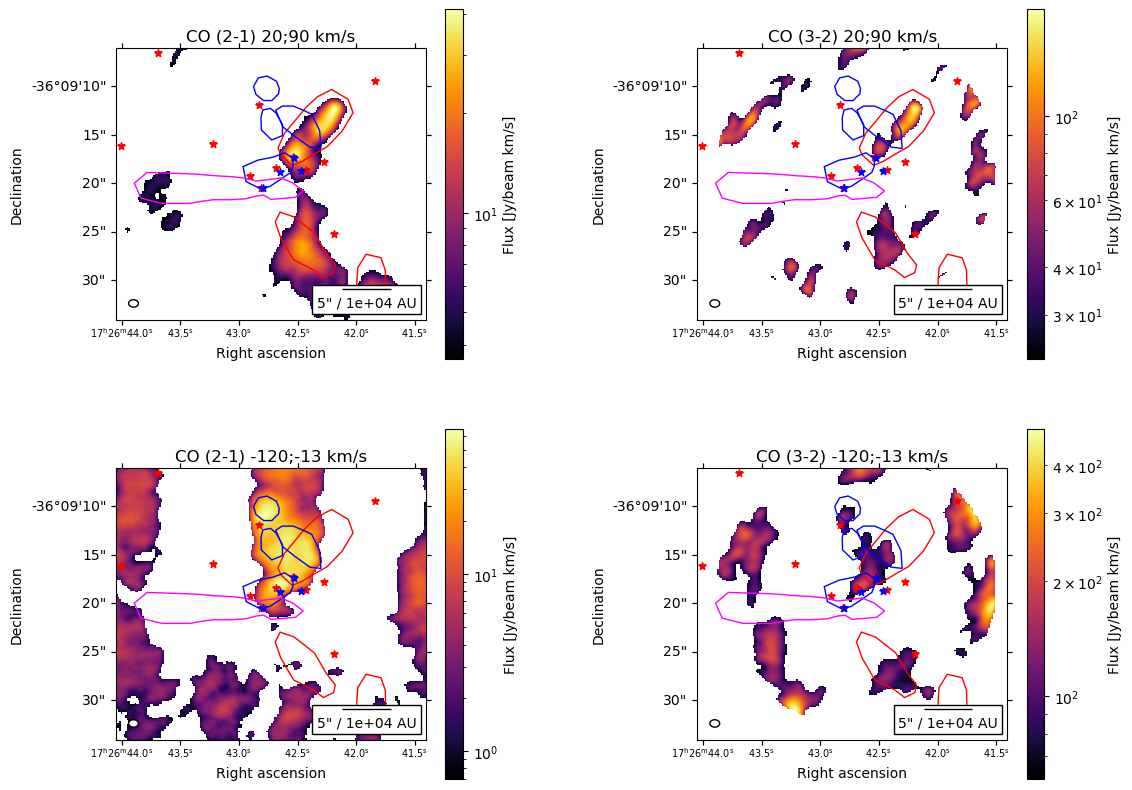

In [4]:
#here the maps are plotted
fig, ax = plt.subplots(2, 2, figsize=(12.5,10), subplot_kw={'projection': wcs_B6_red}) #horizontal size: 25,9.5

ra_red, dec_red = 510, 560
ra_blue, dec_blue = 535, 435


#CO21 redshifted
ax[0,0].imshow(B6_red_clip.value, origin='lower', cmap='inferno', norm=norm_6_red)
ax[0,0].set_title('CO (2-1) ' + red_velrange_text + ' km/s')
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
v.add_beam(ax=ax[0,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='white', edgecolor='black')
ax[0,0].set_xlim(275,475)
ax[0,0].set_ylim(300,475)
ax[0,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_6_red, ax=ax[0,0], label='Flux [Jy/beam km/s]')

#CO32 redshifted
ax[0,1].imshow(B7_red_clip.value, origin='lower', cmap='inferno', norm=norm_7_red)
ax[0,1].set_title('CO (3-2) ' + red_velrange_text + ' km/s')
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
v.add_beam(ax=ax[0,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='white', edgecolor='black')
ax[0,1].set_xlim(275,475)
ax[0,1].set_ylim(300,475)
ax[0,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_7_red, ax=ax[0,1], label='Flux [Jy/beam km/s]')

#CO21 blueshifted
ax[1,0].imshow(B6_blue_clip.value, origin='lower', cmap='inferno', norm=norm_6_blue)
ax[1,0].set_title('CO (2-1) ' + blue_velrange_text + ' km/s')
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
v.add_beam(ax=ax[1,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='white', edgecolor='black')
ax[1,0].set_xlim(275,475)
ax[1,0].set_ylim(300,475)
ax[1,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_6_blue, ax=ax[1,0], label='Flux [Jy/beam km/s]')

#CO32 blueshifted
ax[1,1].imshow(B7_blue_clip.value, origin='lower', cmap='inferno', norm=norm_7_blue)
ax[1,1].set_title('CO (3-2) ' + blue_velrange_text + ' km/s')
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
v.add_beam(ax=ax[1,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='white', edgecolor='black')
ax[1,1].set_xlim(275,475)
ax[1,1].set_ylim(300,475)
ax[1,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_7_blue, ax=ax[1,1], label='Flux [Jy/beam km/s]')


ax[0,0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0,0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores', zorder=10)
ax[0,1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0,1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores', zorder=10)
ax[1,0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1,0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores',zorder=10)
ax[1,1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1,1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores',zorder=10)


ax[0,0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0,0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores')
ax[0,1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1,0].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')

regions = Regions.read('/net/vdesk/data2/bach1/ballieux/master_project_2/data/high_mass_data/apertures_paths_pvdiagrams/G351.77_all', format='crtf')
for region in regions:
    pixel_region = region.to_pixel(wcs_B6_red)
    pixel_region.plot(ax=ax[0,0], linewidth=1)
    pixel_region.plot(ax=ax[0,1], linewidth=1)
    pixel_region.plot(ax=ax[1,0], linewidth=1)
    pixel_region.plot(ax=ax[1,1], linewidth=1)

plt.subplots_adjust(wspace=0.5)
plt.savefig(path+'plots/maps_'+source_name+'.png', bbox_inches='tight', dpi=500)


# LTE Radiative Transfer Magic:

In [5]:
"""
here we do the rotation diagram magic
"""
#beamsize, defined above in arcseconds:
cb_omega = np.pi*((beam_major).to(u.rad).value)*((beam_minor).to(u.rad).value)

#Einstein A coefficients from cmds
A_B6_CO = 10**(-6.1605) /u.s 
A_B7_CO = 10**(-5.6026) /u.s 


In [6]:
#Assuming optically thin:
def column_dens_thin(mom0, A, omega):
    """
    Determine the column density of a molecule in the optically thin limit. since it gives an overflow error, and 
    returns only infinite sometimes, we first multiply the denomenator with 1e38 and later multiply the whole again by 1e38 to get the correct units.
    """
    numerator = 4 * np.pi * mom0 
    denomenator = A * omega * c.h * c.c *1e38
    coldens = numerator / denomenator  
    return coldens.to(u.cm**(-2)) *1e38

In [7]:
#Determine the column densities in the 2 bands for the red and blueshifted lines
coldens_B6_CO_red = column_dens_thin(B6_red_clip, A_B6_CO, cb_omega)
coldens_B7_CO_red = column_dens_thin(B7_red_clip, A_B7_CO, cb_omega)
coldens_B6_CO_blue = column_dens_thin(B6_blue_clip, A_B6_CO, cb_omega)
coldens_B7_CO_blue = column_dens_thin(B7_blue_clip, A_B7_CO, cb_omega)


In [8]:
# coldens_red_mask_behaved = (coldens_B6_CO_red.value<7.91e15) & (coldens_B7_CO_red.value<5.54e15)
# coldens_blue_mask_behaved = (coldens_B6_CO_blue.value<7.91e15) & (coldens_B7_CO_blue.value<5.54e15)

#from cdms, the degeneracies of the CO molecule
g_B6 = 5
g_B7 = 7

#Rest frequencies
freq_B6_CO = 230538.0000 *u.Hz*c.h
freq_B7_CO = 345795.9899 *u.Hz*c.h
  
#Lower energies
El_B6_CO = 3.8450 *1.438 * u.K #*u.cm**(-1)*c.h*c.c
El_B7_CO = 11.535 *1.438 * u.K #*u.cm**(-1)*c.h*c.c

Eu_B6_CO = 11.5350 * 1.438 * u.K
Eu_B7_CO = 23.0695 * 1.438 * u.K


In [18]:
#here we calculate the rotational temperatures, unmasked
rot_ratio_CO_red = (np.log(coldens_B6_CO_red.value/g_B6)-np.log(coldens_B7_CO_red.value/g_B7))/(Eu_B6_CO-Eu_B7_CO)
rot_ratio_CO_blue = (np.log(coldens_B6_CO_blue.value/g_B6)-np.log(coldens_B7_CO_blue.value/g_B7))/(Eu_B6_CO-Eu_B7_CO)

Tk_CO_red = -1/rot_ratio_CO_red
Tk_CO_blue = -1/rot_ratio_CO_blue

"""   
The propagation of errors is done in the following way:
find uncertainty in the line column densities which is linearly dependent on the error in the moment 0 map, 
so just enter into the equation. Then we have a formula for the slope, so standard prop of errors
gives us the uncertainty in the slope. The rotational temperature is then calculated from the slope, so we can
do more standard propagation of errors to find the uncertainty in the rotational temperature.

"""
sigma_coldens_B6_red = column_dens_thin(B6_red_err, A_B6_CO, cb_omega) 
sigma_coldens_B6_blue = column_dens_thin(B6_blue_err, A_B6_CO, cb_omega)
sigma_coldens_B7_red = column_dens_thin(B7_red_err, A_B7_CO, cb_omega)
sigma_coldens_B7_blue = column_dens_thin(B7_blue_err, A_B7_CO, cb_omega)

#from prop of errors
sigma_slope_red = np.sqrt(((sigma_coldens_B6_red/coldens_B6_CO_red)/(Eu_B6_CO-Eu_B7_CO))**2 + ((sigma_coldens_B7_red/coldens_B7_CO_red)/(Eu_B6_CO-Eu_B7_CO))**2)
sigma_slope_blue = np.sqrt(((sigma_coldens_B6_blue/coldens_B6_CO_blue)/(Eu_B6_CO-Eu_B7_CO))**2 + ((sigma_coldens_B7_blue/coldens_B7_CO_blue)/(Eu_B6_CO-Eu_B7_CO))**2)

#The errors on the rotational temperatures
sigma_Tk_red = sigma_slope_red/(rot_ratio_CO_red**2)
sigma_Tk_blue = sigma_slope_blue/(rot_ratio_CO_blue**2)

#For visualisation later, the min, max or mean is not representative
print('Tk red:', np.mean(Tk_CO_red[~np.isnan(Tk_CO_red)]), 'Tk blue:', np.mean(Tk_CO_blue[~np.isnan(Tk_CO_blue)]))
print('Tk red max:', np.max(Tk_CO_red[~np.isnan(Tk_CO_red)]), 'Tk blue max:', np.max(Tk_CO_blue[~np.isnan(Tk_CO_blue)])) #This probably includes off pixels
print('Tk red min:', np.min(Tk_CO_red[~np.isnan(Tk_CO_red)]), 'Tk blue min:', np.min(Tk_CO_blue[~np.isnan(Tk_CO_blue)])) #This includes negative pixels
print('sigma_Tk red:', np.mean(sigma_Tk_red[~np.isnan(sigma_Tk_red)]), 'sigma_Tk blue:', np.mean(sigma_Tk_blue[~np.isnan(sigma_Tk_blue)]))


Tk red: 31.890581902498386 K Tk blue: -6.345540777505512 K
Tk red max: 3498.9476441948746 K Tk blue max: 1065.1735482719257 K
Tk red min: -661.5050858850042 K Tk blue min: -10643.931148061578 K
sigma_Tk red: 356.2296766807474 K sigma_Tk blue: 712.0831434223077 K


In [10]:
#required to plot the colorbars
norm_T = mpl.colors.LogNorm(vmin=1e1, vmax=1e2)
norm_d = mpl.colors.LogNorm(vmin=5e16, vmax=1e18)
sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

In [16]:
#interpolate to find the partition function for each pixel
Z_CO = np.array([1.4053, 2.1824, 3.7435, 7.1223, 13.8965, 27.4545, 54.5814, 81.7184, 108.8651, 181.3025, 362.6910, 726.7430])
T = np.array([2.725, 5.000, 9.375, 18.75, 37.5, 75, 150, 225, 300, 500, 1000, 2000])*u.K

#Everything that behaves as expected in terms of temperature
temp_behaved_mask_CO_red = (Tk_CO_red<1000*u.K) & (Tk_CO_red>1*u.K)
temp_behaved_mask_CO_blue = (Tk_CO_blue<1000*u.K) & (Tk_CO_blue>1*u.K)

#this is the temperatures where column density behaves
Tk_CO_red_behaved = np.copy(Tk_CO_red)
Tk_CO_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
Tk_CO_blue_behaved = np.copy(Tk_CO_blue)
Tk_CO_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan

sigma_Tk_red_behaved = np.copy(sigma_Tk_red)
sigma_Tk_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
sigma_Tk_blue_behaved = np.copy(sigma_Tk_blue)
sigma_Tk_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan

Z_interp_CO = interp.interp1d(T, Z_CO, kind='linear', fill_value='extrapolate')

Z_CO_red = Z_interp_CO(Tk_CO_red)
Z_CO_blue = Z_interp_CO(Tk_CO_blue)



In [19]:
def N_tot(N_u, g_u, Z, E_u, Tk):

    """
    Determine the total column density of a molecule in the optically thin limit.
    """
    return N_u*Z*np.exp(E_u/Tk)/g_u

#determine the total column densities, even for the ones that are optically thick to see how it behaves
N_B6_CO_red = N_tot(coldens_B6_CO_red, g_B6, Z_CO_red, Eu_B6_CO, Tk_CO_red)
N_B6_CO_blue = N_tot(coldens_B6_CO_blue, g_B6, Z_CO_blue, Eu_B6_CO, Tk_CO_blue)

N_B6_CO_red_behaved = np.copy(N_B6_CO_red)
N_B6_CO_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
N_B6_CO_blue_behaved = np.copy(N_B6_CO_blue)
N_B6_CO_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan


In [20]:
"""  
Uncertainty in coldens
We do propagation of errors on the formula for Ntot. 3 parameters that are uncertain: N_u, Tk en Z. 
Ignore uncertainty on Z, do standard prop of errors on N_u and Tk.
"""

sigma_Ntot_B6_red = np.sqrt((N_tot(sigma_coldens_B6_red, g_B6, Z_CO_red, Eu_B6_CO, Tk_CO_red))**2 + (N_B6_CO_red*Eu_B6_CO*sigma_Tk_red/(g_B6*Tk_CO_red**2))**2)
sigma_Ntot_B6_blue = np.sqrt((N_tot(sigma_coldens_B6_blue, g_B6, Z_CO_blue, Eu_B6_CO, Tk_CO_blue))**2 + (N_B6_CO_blue*Eu_B6_CO*sigma_Tk_blue/(g_B6*Tk_CO_blue**2))**2)

sigma_Ntot_B6_red_behaved = np.copy(sigma_Ntot_B6_red)
sigma_Ntot_B6_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
sigma_Ntot_B6_blue_behaved = np.copy(sigma_Ntot_B6_blue)
sigma_Ntot_B6_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan

print('sigma N red:', np.mean(sigma_Ntot_B6_red_behaved[~np.isnan(sigma_Ntot_B6_red_behaved)]), 'sigma N blue:', np.mean(sigma_Ntot_B6_blue_behaved[~np.isnan(sigma_Ntot_B6_blue_behaved)]))

sigma N red: 1.7679969413597644e+16 1 / cm2 sigma N blue: 2.9325510283397956e+16 1 / cm2


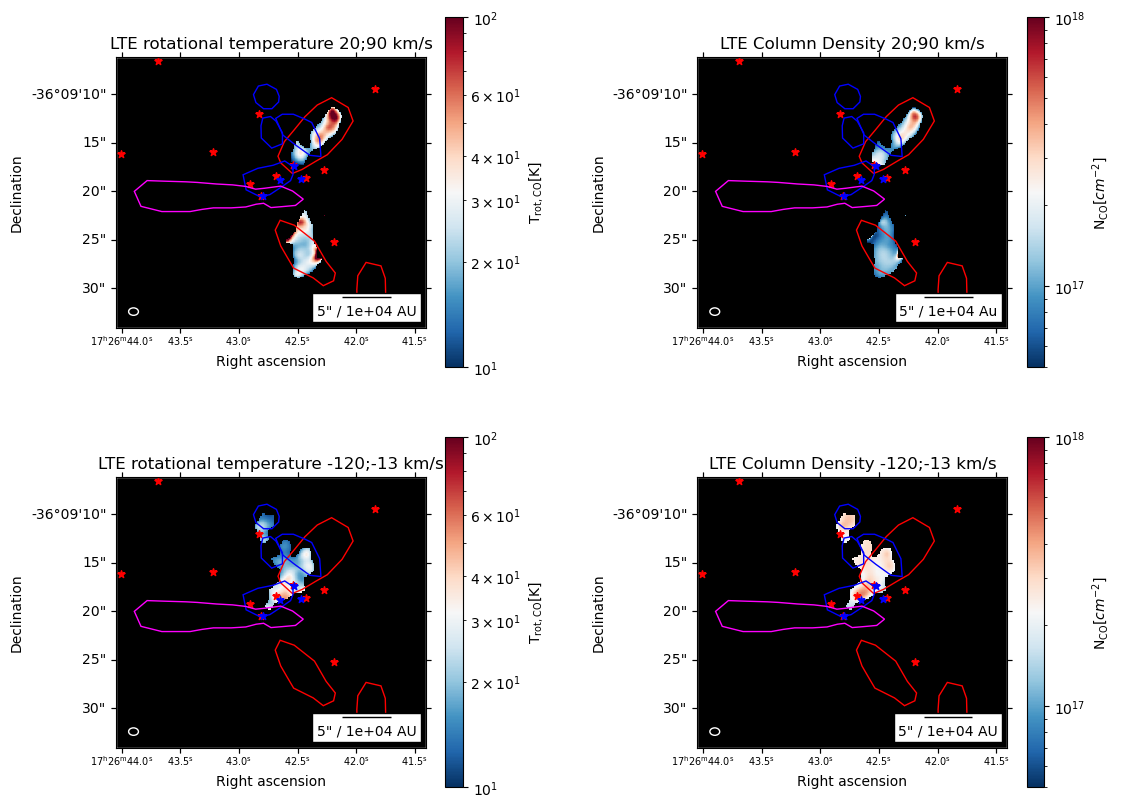

In [13]:
#Do the plottomg pf rotational temperature and total column density
fig, ax = plt.subplots(2,2, figsize=(12.5,10), subplot_kw={'projection': wcs_B6_red}) #size horizontal: 20,9.5

#temp red
ax[0,0].imshow(Tk_CO_red_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_T)
ax[0,0].set_facecolor('black')
ax[0,0].set_title('LTE rotational temperature '+red_velrange_text+' km/s')
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
v.add_beam(ax=ax[0,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
ax[0,0].set_xlim(275,475)
ax[0,0].set_ylim(300,475)
ax[0,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_T, ax=ax[0,0], label=r'T$_{\mathrm{rot,CO}}$[K]')

#temp blue
ax[1,0].imshow(Tk_CO_blue_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_T)
ax[1,0].set_facecolor('black')
ax[1,0].set_title('LTE rotational temperature '+blue_velrange_text+' km/s')
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
ax[1,0].set_xlim(275,475)
ax[1,0].set_ylim(300,475)
v.add_beam(ax=ax[1,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
ax[1,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_T, ax=ax[1,0], label=r'T$_{\mathrm{rot,CO}}$[K]')

#coldens red
ax[0,1].imshow(N_B6_CO_red_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_d)
ax[0,1].set_facecolor('black')
ax[0,1].set_title('LTE Column Density '+red_velrange_text+' km/s')
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
ax[0,1].set_xlim(275,475)
ax[0,1].set_ylim(300,475)
v.add_beam(ax=ax[0,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
ax[0,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} Au", frame=True, pad=0.3)
fig.colorbar(mappable=sm_d, ax=ax[0,1], label=r'N$_{\mathrm{CO}}[cm^{-2}]$')

#coldens blue
ax[1,1].imshow(N_B6_CO_blue_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_d)
ax[1,1].set_facecolor('black')
ax[1,1].set_title('LTE Column Density '+blue_velrange_text+' km/s')
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
ax[1,1].set_xlim(275,475)
ax[1,1].set_ylim(300,475)
v.add_beam(ax=ax[1,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
ax[1,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_d, ax=ax[1,1], label=r'N$_{\mathrm{CO}}[cm^{-2}]$')


ax[0,0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0,0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores', zorder=10)
ax[0,1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0,1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores', zorder=10)
ax[1,0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1,0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores',zorder=10)
ax[1,1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1,1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores',zorder=10)

ax[0,0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0,0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores')
ax[0,1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1,0].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')

for region in regions:
    pixel_region = region.to_pixel(wcs_B6_red)
    pixel_region.plot(ax=ax[0,0], linewidth=1)
    pixel_region.plot(ax=ax[0,1], linewidth=1)
    pixel_region.plot(ax=ax[1,0], linewidth=1)
    pixel_region.plot(ax=ax[1,1], linewidth=1)

plt.subplots_adjust(wspace=0.5)
plt.savefig(path+'plots/LTE_tempmaps_'+source_name+'.png', dpi=500, bbox_inches='tight')

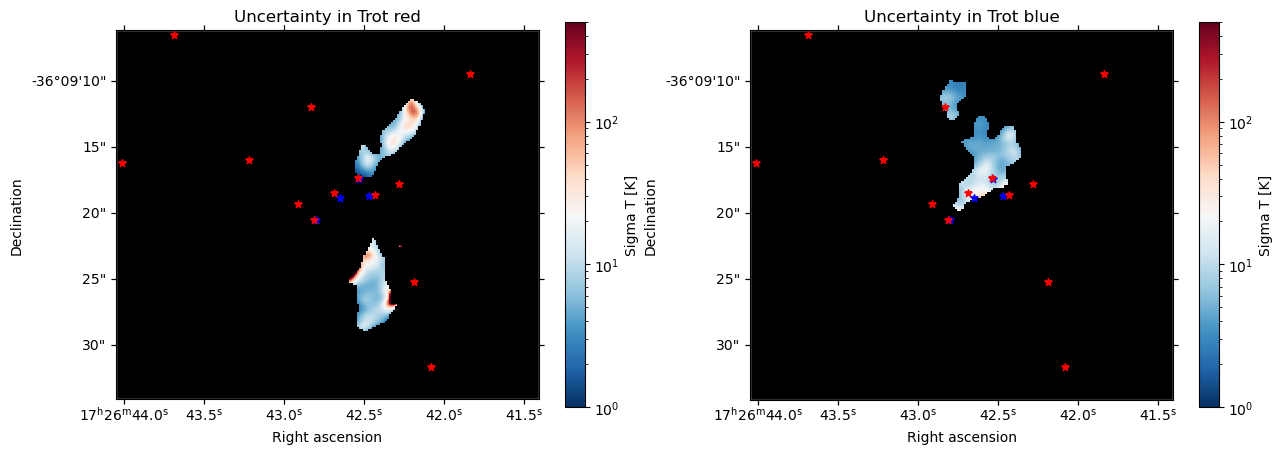

In [21]:
"""   
Plot the sigma on temperature

"""

#required to plot the colorbars
norm_ratio_sigma_T = mpl.colors.LogNorm(vmin=1, vmax=5e2)
sm_ratio_sigma_T = cm.ScalarMappable(norm=norm_ratio_sigma_T, cmap=cmap)

#trying to figure out why some spots disappear/are very high
fig, ax = plt.subplots(1,2, figsize=(15,5), subplot_kw={'projection': wcs_B6_red}) #size horizontal: 20,9.5

#ratio red
ax[0].imshow(sigma_Tk_red_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_ratio_sigma_T)
ax[0].set_facecolor('black')
ax[0].set_title('Uncertainty in Trot red')
ax[0].set_xlabel('Right ascension')
ax[0].set_ylabel('Declination')
v.add_beam(ax=ax[0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[0].set_xlim(275,475)
ax[0].set_ylim(300,475)
v.add_scalebar(ax[0], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_ratio_sigma_T, ax=ax[0], label='Sigma T [K]')

#ratio blue
ax[1].imshow(sigma_Tk_blue_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_ratio_sigma_T)
ax[1].set_facecolor('black')
ax[1].set_title('Uncertainty in Trot blue')
ax[1].set_xlabel('Right ascension')
ax[1].set_ylabel('Declination')
v.add_beam(ax=ax[1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1].set_xlim(275,475)
ax[1].set_ylim(300,475)
v.add_scalebar(ax[1], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_ratio_sigma_T, ax=ax[1], label='Sigma T [K]')


ax[0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores')
ax[1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores')

ax[0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores', zorder=100)
ax[1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
for region in regions:
    pixel_region = region.to_pixel(wcs_B7_red)
    pixel_region.plot(ax=ax[0], linewidth=1)
    pixel_region.plot(ax=ax[1], linewidth=1)

# plt.subplots_adjust(wspace=0.5)
# plt.savefig(path+'plots/ratio_flux.png', bbox_inches='tight')

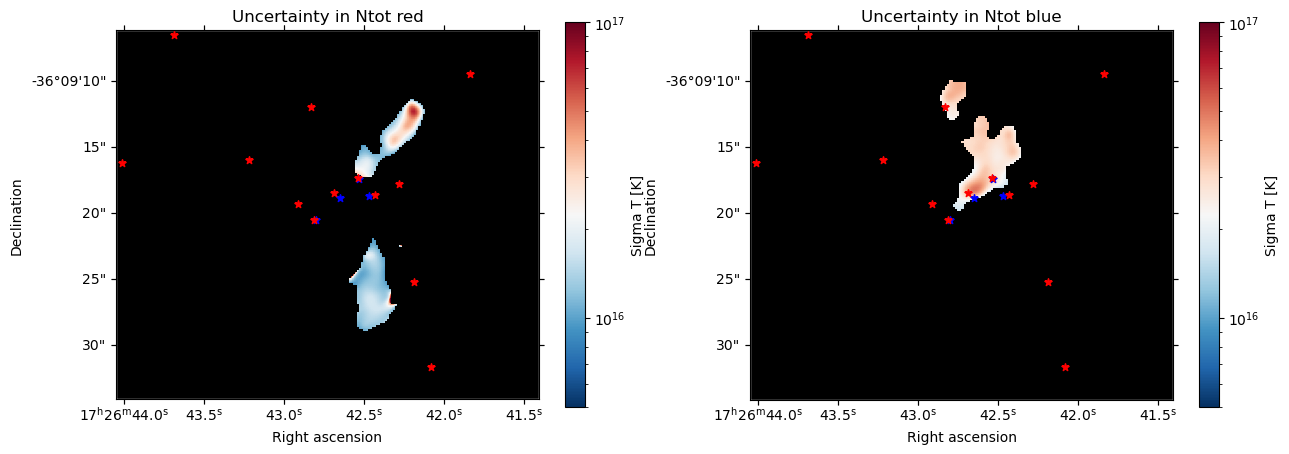

In [26]:
"""   
Plot the sigma on uncertainty

"""

#required to plot the colorbars
norm_ratio_sigma_N = mpl.colors.LogNorm(vmin=5e15, vmax=1e17)
sm_ratio_sigma_N = cm.ScalarMappable(norm=norm_ratio_sigma_N, cmap=cmap)

#trying to figure out why some spots disappear/are very high
fig, ax = plt.subplots(1,2, figsize=(15,5), subplot_kw={'projection': wcs_B6_red}) #size horizontal: 20,9.5

#ratio red
ax[0].imshow(sigma_Ntot_B6_red_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_ratio_sigma_N)
ax[0].set_facecolor('black')
ax[0].set_title('Uncertainty in Ntot red')
ax[0].set_xlabel('Right ascension')
ax[0].set_ylabel('Declination')
v.add_beam(ax=ax[0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[0].set_xlim(275,475)
ax[0].set_ylim(300,475)
v.add_scalebar(ax[0], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_ratio_sigma_N, ax=ax[0], label='Sigma T [K]')

#ratio blue
ax[1].imshow(sigma_Ntot_B6_blue_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_ratio_sigma_N)
ax[1].set_facecolor('black')
ax[1].set_title('Uncertainty in Ntot blue')
ax[1].set_xlabel('Right ascension')
ax[1].set_ylabel('Declination')
v.add_beam(ax=ax[1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1].set_xlim(275,475)
ax[1].set_ylim(300,475)
v.add_scalebar(ax[1], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_ratio_sigma_N, ax=ax[1], label='Sigma T [K]')


ax[0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores')
ax[1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores')

ax[0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores', zorder=100)
ax[1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
for region in regions:
    pixel_region = region.to_pixel(wcs_B7_red)
    pixel_region.plot(ax=ax[0], linewidth=1)
    pixel_region.plot(ax=ax[1], linewidth=1)

# plt.subplots_adjust(wspace=0.5)
# plt.savefig(path+'plots/ratio_flux.png', bbox_inches='tight')

1.1495169401168823 Jy km / s 0.22140826284885406 Jy km / s
Length of the line red lobe A: 1.475e+04 pm 2.508e+03 AU
Length of the line red lobe B: 2.739e+04 pm 3.408e+03 AU

Delta V red 1.29e+02 km / s pm 12.9 km / s
Delta V red 1.05e+02 km / s pm 10.5 km / s
The red A dynamic time is 541.7 pm 106.8 years
The red B dynamic time is 1.236e+03 pm 197.4 years


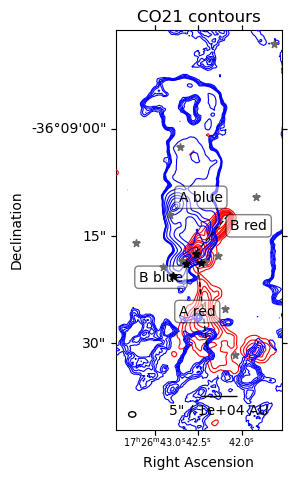

In [14]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': wcs_B6_red}) #size horizontal: 20,9.5
plt.title('CO21 contours')

# Plot the contours of B6_red_clip. since it is already clipped at 3 sigma, no need to do it again. This goed allright, it does not need to be 3sigma for b6 _and_ b7.
contourlevels_red=np.array([3,6,9,12,15,18.21,24,27,30])*B6_red_rms
ax.contour(B6_red.value, levels=contourlevels_red, colors='red', linewidths=0.8)

# Plot the contours of B6_blue_clip
#TODO: note down that here the sigma levels are different, or fix them
contourlevels_blue=np.array([3,6,9,12,15,50,100,150,200,250,275, 300,350])* B6_blue_rms
ax.contour(B6_blue.value, levels=contourlevels_blue, colors='blue', linewidths=0.8)
print(B6_red_rms, B6_blue_rms)  

# Set the aspect ratio to be equal
ax.set_aspect('equal')

# Set the limits for zooming
ax.set_xlim(320,465)
ax.set_ylim(250,600)

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

plt.text(375,450, 'A blue', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))
plt.text(375,350, 'A red', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))
plt.text(340,380, 'B blue', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))
plt.text(420,425, 'B red', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))

v.add_beam(ax=ax,major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax.tick_params(axis='x', labelsize=7)
v.add_scalebar(ax, length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU")
ax.scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax.get_transform('fk5'), s=30, 
              color='dimgrey', marker='*', label='All cores', zorder=10)

ax.scatter(hot_cores_RA, hot_cores_DEC, transform=ax.get_transform('fk5'), s=30,
           color='black', marker='*', label='Hot cores', zorder=100)

#make radii
point1_redA = (390, 405)  # protostar    
point2_redA = (420, 440)  # Furthest point from the protostar
ax.plot([point1_redA[0], point2_redA[0]], [point1_redA[1], point2_redA[1]], color='black', linestyle='--', linewidth=1)
line_length_redA = np.sqrt((point2_redA[0] - point1_redA[0])**2 + (point2_redA[1] - point1_redA[1])**2)

point1_redB = (390, 405)  # protostar    
point2_redB = (400, 320)  # Furthest point from the protostar
ax.plot([point1_redB[0], point2_redB[0]], [point1_redB[1], point2_redB[1]], color='black', linestyle='--', linewidth=1)
line_length_redB = np.sqrt((point2_redB[0] - point1_redB[0])**2 + (point2_redB[1] - point1_redB[1])**2)

V_redA = np.abs(126.1 - (-3)) * u.km / u.s
V_redB = np.abs(102.0 - (-3)) * u.km / u.s

# Show the plot
plt.tight_layout()
plt.savefig(path+'plots/CO21_contours_'+source_name+'.png', dpi=600, bbox_inches='tight')

#Uncertainty in radius is 10% of lobe convolved with major axis of beam
radius_redA = ((line_length_redA * pixel_size).to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())
e_radius_redA = np.sqrt( np.square(0.1* radius_redA) + np.square((beam_major.to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())) )
print(f"Length of the line red lobe A: {radius_redA.value:.4} pm {e_radius_redA.value:.4} AU")
radius_redB = ((line_length_redB * pixel_size).to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())
e_radius_redB = np.sqrt( np.square(0.1* radius_redB) + np.square((beam_major.to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())) )
print(f"Length of the line red lobe B: {radius_redB.value:.4} pm {e_radius_redB.value:.4} AU")


print("")
e_V_redA= 0.1 * V_redA
print(f"Delta V red {V_redA:.3} pm {e_V_redA:.3}")
e_V_redB= 0.1 * V_redB
print(f"Delta V red {V_redB:.3} pm {e_V_redB:.3}")


t_dyn_redA = (radius_redA / V_redA).to(u.yr)
e_t_dyn_redA = np.sqrt(np.square(e_radius_redA/V_redA)+np.square(radius_redA * e_V_redA/ V_redA **2)).to(u.yr)
print(f"The red A dynamic time is {t_dyn_redA.value:.4} pm {e_t_dyn_redA.value:.4} years")

t_dyn_redB = (radius_redB / V_redB).to(u.yr)
e_t_dyn_redB = np.sqrt(np.square(e_radius_redB/V_redB)+np.square(radius_redB * e_V_redB/ V_redB **2)).to(u.yr)
print(f"The red B dynamic time is {t_dyn_redB.value:.4} pm {e_t_dyn_redB.value:.4} years")




In [15]:
# #required to plot the colorbars
# norm_ratio = mpl.colors.LogNorm(vmin=1e-1, vmax=1e0)
# sm_ratio = cm.ScalarMappable(norm=norm_ratio, cmap=cmap)

# #trying to figure out why some spots disappear/are very high
# fig, ax = plt.subplots(1,2, figsize=(15,5), subplot_kw={'projection': wcs_B6_red}) #size horizontal: 20,9.5

# #ratio red
# ax[0].imshow(B6_red_clip/B7_red_clip, origin='lower', cmap='RdBu_r', norm=norm_ratio)
# ax[0].set_facecolor('black')
# ax[0].set_title('CO21/CO32 ratio red')
# ax[0].set_xlabel('Right ascension')
# ax[0].set_ylabel('Declination')
# v.add_beam(ax=ax[0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
# ax[0].set_xlim(275,475)
# ax[0].set_ylim(300,475)
# v.add_scalebar(ax[0], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
# fig.colorbar(mappable=sm_ratio, ax=ax[0], label='ratio CO21/CO32')

# #ratio blue
# ax[1].imshow(B6_blue_clip/B7_blue_clip, origin='lower', cmap='RdBu_r', norm=norm_ratio)
# ax[1].set_facecolor('black')
# ax[1].set_title('CO21/CO32 ratio blue')
# ax[1].set_xlabel('Right ascension')
# ax[1].set_ylabel('Declination')
# v.add_beam(ax=ax[1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
# ax[1].set_xlim(275,475)
# ax[1].set_ylim(300,475)
# v.add_scalebar(ax[1], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
# fig.colorbar(mappable=sm_ratio, ax=ax[1], label='ratio CO21/CO32')

# for region in regions:
#     pixel_region = region.to_pixel(wcs_B6_red)
#     pixel_region.plot(ax=ax[0], linewidth=1)
#     pixel_region.plot(ax=ax[1], linewidth=1)

# ax[0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0].get_transform('fk5'), s=30,
#            color='blue', marker='*', label='Hot cores')
# ax[1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1].get_transform('fk5'), s=30,
#            color='blue', marker='*', label='Hot cores')

# ax[0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0].get_transform('fk5'), s=30, 
#               color='red', marker='*', label='All cores', zorder=100)
# ax[1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1].get_transform('fk5'), s=30,
#                 color='red', marker='*', label='All cores')

# plt.subplots_adjust(wspace=0.5)
# plt.savefig(path+'plots/ratio_flux.png', bbox_inches='tight')